# 1. Motivation. Edible Networks?

We love food. Who doesn't? We decided it would be a great topic to explore. We've seen many studies about food and we were curious about approaching it as a network. That's how our search for food datasets started. We found many great recipe websites but very few of them offered APIs, and they were expensive. So one option was to scrape some websites ourselves. Before resorting to that, though, we found a great dataset available online.

[Kaggle](https://kaggle.com) is an online data science platform to learn, share and compete with other users. [One past competition](https://www.kaggle.com/c/whats-cooking) hosted by [Yummly](http://www.yummly.com/) offered a relatively big dataset of recipes. It contains a list of recipes classified by cuisine, with lists of ingredients already semi curated. The drawbacks are that the recipes aren't named and don't contain the preparation method. However, since we weren't planning on doing much with those and the format of the dataset is really comfortable we chose it over web scraping. This will be our main dataset we will be working with.

To do more work on natural language processing, we will also fetch a collection of tweets mentioning the different cuisines of our dataset. We'll study their sentiment in an attempt to understand people's preferences when talking about world food.

Our goal for the public is to provide an insight about how the cuisines around the world are linked and what are their most significant ingredients, that is, to spread a deeper knowledge about world cuisines. As an addition, if the time allows it we will make a simple recipe name generator to name the recipes found in the dataset.

# 2. Basic stats. More about the dataset

Our dataset consists of a JSON file with a list of recipes. Each recipe contains an id, the cuisine it belongs to, and a list of ingredients. The first steps of our analysis involve loading the dataset and creating some python objects to explore it.

In [4]:
import json
import io

trainfile = io.open('train.json')
traindata = json.load(trainfile)

In [5]:
print "The dataset contains information on %d recipes." % len(traindata)

The dataset contains information on 39774 recipes.


In [6]:
# build dict of recipes: id -> recipe {id, cuisine, ingredients}
recipes = dict((x['id'], x) for x in traindata[:1000])

# This way we can access by recipe id
print recipes[25693]

{u'cuisine': u'southern_us', u'id': 25693, u'ingredients': [u'plain flour', u'ground pepper', u'salt', u'tomatoes', u'ground black pepper', u'thyme', u'eggs', u'green tomatoes', u'yellow corn meal', u'milk', u'vegetable oil']}


We build a set of all the **ingredients** contained in the dataset.

In [7]:
# Build set of ingredients
ingredients_set = set(x for r in recipes.values() for x in r['ingredients'])

print "There are %d different ingredients (before cleaning)" % len(ingredients_set)

ing = ['salt', 'brain', 'eggs', 'white pepper', 'black pepper']

for i in ing:
    b = 'NOT ' if not i in ingredients_set else ''
    print " - %s is %san ingredient of the dataset" % (i, b)

There are 1817 different ingredients (before cleaning)
 - salt is an ingredient of the dataset
 - brain is NOT an ingredient of the dataset
 - eggs is an ingredient of the dataset
 - white pepper is an ingredient of the dataset
 - black pepper is an ingredient of the dataset


As we see in the previous examples, the ingredients have many different forms: singular, plural, more generic or more detailed. In order to make them more 'homogeneus', we'll clean them all. The goal is to group ingredients that are written differently but are actually the same. So we'll convert them to lowercase, remove symbols and lemmatize them (make all the words singular).

In [8]:
def clean_ingredient(ingredient, stemmer):
    
    ingredient = ingredient.lower()
    
    def remove_symbols(c):
        return c.replace('\'', '').replace('\\', '').replace(',','') \
                .replace('&', '').replace('(', '').replace(')','')   \
                .replace('.', '').replace('%', '').replace('/','')   \
                .replace('"', '')
    
    ingredient = remove_symbols(ingredient)
    
    ingredient = ' '.join([stemmer.lemmatize(w) for w in ingredient.split(' ')])
    
    return ingredient

In [9]:
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

i = 'Blanched Almonds'
print i
print clean_ingredient(i, stemmer)

print '\nThe "chicken problem": '+', '.join([x for r in recipes.values() for x in r['ingredients']  if 'chicken' in x][:9])+'...'


Blanched Almonds
blanched almond

The "chicken problem": lower sodium chicken broth, chicken broth, chicken, fat free less sodium chicken broth, reduced sodium chicken broth, chicken broth, bone-in chicken breast halves, chicken drumsticks, chicken broth...


In [10]:
# We 'clean' all the ingredients

clean_ingredients_set = set()

for r in recipes.values():
    for ing in r['ingredients']:
        clean_ingredients_set.add(clean_ingredient(ing, stemmer))

In [11]:
clean_ingredients_set = set(x for r in recipes.values() for x in r['ingredients'])

print "There are %d different ingredients (after cleaning)" % len(ingredients_set)

There are 1817 different ingredients (after cleaning)


We see that **we didn't really _remove_ any duplicated ingredient!** After all, it seems that the cleaning wasn't worth it. We will work with the original ingredients. Another cleaning step we were planning to do was more complex: merge synonims or very similar ingredients. For example, we could consider that _boneless chicken_ and _boneless chicken breast_ are the same. 

In order to achieve this extra homogeinity, we tried to apply some NLP with ideas like removing adjectives. However the results were not near satisfactory. It's not simple to decide algorithmically what pairs of ingredients are to be considered the same one and what are _different_ enough to not be merged into one, since that is a a subjective measure. For example, one could argue that it's better to keep _white pepper_ and _black pepper_ as different ingredients. Maybe they are representatives of two different cuisines and merging them would limit the accuracy of our analysis.

Here are a few other stats about the dataset.

In [15]:
import numpy as np
from tabulate import tabulate

print 'The mean number of ingredients per recipe is %.1f' % np.mean([len(r['ingredients']) for r in recipes.values()])
print '\nThe number of recipes per each cuisine is:'
print tabulate([(c, len([r for r in recipes.values() if r['cuisine'] == c])) for c in set([x['cuisine'] for x in recipes.values()])])

The mean number of ingredients per recipe is 10.7

The number of recipes per each cuisine is:
------------  ---
british        16
irish          19
mexican       177
filipino       16
chinese        67
vietnamese     18
brazilian      12
japanese       39
french         60
greek          31
indian         76
cajun_creole   35
moroccan       18
spanish        25
russian        11
jamaican       14
thai           29
southern_us    95
korean         31
italian       211
------------  ---


# 3. Tools, theory and analysis. Description of the process 

## Creating the network

First step: create the network! As explained in the introductory video, the graph we create is a weighted graph.

Every ingredient is a node. Two nodes are connected if there is a recipe that uses both of them. The weight of an edge is the number of recipes shared by its two nodes.

In [9]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(ingredients_set)

for r in recipes.values():
    for i in r['ingredients']:
        for j in r['ingredients']:
            if G.has_edge(i, j):
                G[i][j]['weight'] += 1.0
            else:
                G.add_edge(i, j, {'weight': 1.0})

In [10]:
import numpy as np

degree = nx.degree(G, weight='weight')
print 'The average degree of the nodes is %.3f' % np.mean(degree.values())
print 'The median of the degree of the nodes is %d' % np.median(degree.values())

The average degree of the nodes is 148.807
The median of the degree of the nodes is 40


Let's visualize the degrees in a graphical way.

First, what are the top 10 ingredients by degree?

In [11]:
from tabulate import tabulate

degree = nx.degree(G, weight='weight')
data = [(x, degree[x]) for x in sorted(degree, key=degree.get, reverse=True)][:10]
print tabulate(data, headers=('Ingredient', 'Degree'))

Ingredient             Degree
-------------------  --------
salt                    10386
garlic                   5592
onions                   5232
olive oil                5144
water                    4208
ground black pepper      3430
garlic cloves            3410
sugar                    3256
butter                   2784
pepper                   2766


It doesn't come as a surprise that the salt is the most used ingredient. All the top 10 are really common ingredients, as expected.

In [12]:
import matplotlib.pylab as plt
%matplotlib inline
# nx.draw(G)

# For graph visualization, we used the
# program GEFI, which is faster and interactive.

## Cuisine types

Let's extract the different cuisines mentioned in the recipes we have and start studying them.

In [13]:
cuisine_types = set()

for x in traindata:
    cuisine_types.add(x['cuisine'])

print "The available recipes belong to %d different types of cuisine:" % len(cuisine_types)
print ', '.join(cuisine_types)

The available recipes belong to 20 different types of cuisine:
irish, mexican, chinese, filipino, vietnamese, moroccan, brazilian, japanese, british, greek, indian, jamaican, french, spanish, russian, cajun_creole, thai, southern_us, korean, italian


The first step in the study of cuisines and its ingredients will be assigning each ingredient to one single cuisine - the one it is a more important part of. Right now, an ingredient that belongs to different recipes might belong to different cuisines as well, if its recipes belong to different cuisines. The goal now is to decide which of those cuisines the ingredient should be assigned to. 

To achieve this, we propose two methods. Both start assigning the ingredients that appear in recipes of only one cuisine to that cuisine. The difference is in how to classify the _multi-cuisine_ ingredients. Find the explanations as code comments.

In [14]:
# First, add a list to every node with their (maybe multiple) cuisines
for n in G.node:
    
    recipes_of_n = [r for r in recipes.values() if n in r['ingredients']]
    G.node[n]['cuisine_freq'] = {c : len([r for r in recipes_of_n if r['cuisine'] == c]) for c in cuisine_types}
    
    c = set([x['cuisine'] for x in recipes.values() if n in x['ingredients']])
    G.node[n]['cuisines'] = c

In [15]:
print 'cuisines: ' + ', '.join(G.node['soy sauce']['cuisines'])
print
print 'frequencies:', G.node['soy sauce']['cuisine_freq']

cuisines: mexican, filipino, chinese, vietnamese, japanese, indian, jamaican, korean, thai

frequencies: {u'irish': 0, u'mexican': 2, u'chinese': 35, u'filipino': 5, u'vietnamese': 6, u'spanish': 0, u'japanese': 8, u'moroccan': 0, u'french': 0, u'greek': 0, u'indian': 2, u'jamaican': 1, u'british': 0, u'brazilian': 0, u'russian': 0, u'cajun_creole': 0, u'thai': 4, u'southern_us': 0, u'korean': 15, u'italian': 0}


In [16]:
# idea A
# an ingredient n belongs to the
# cuisine C if C is the most common
# cuisine among n's neighbors that are
# unique of a cuisine


# Find the ingredients unique
# of one single cuisine
assert len([n for n in G.node if len(G.node[n]['cuisines']) == 0]) == 0
ingredients_single_cuisine = [n for n in G.node if len(G.node[n]['cuisines']) == 1]

print "There are %d (out of %d) ingredients that belong to just one cuisine" % (len(ingredients_single_cuisine), len(ingredients_set))

There are 1056 (out of 1817) ingredients that belong to just one cuisine


In [17]:
print 'These are some of them'
print tabulate([(i, list(G.node[i]['cuisines'])[0]) for i in ingredients_single_cuisine][:10])

These are some of them
----------------------  -----------
red cabbage             thai
fava beans              italian
veget soup mix          spanish
peeled deveined shrimp  mexican
tandoori spices         indian
pancetta                italian
vegan parmesan cheese   italian
biscuit baking mix      southern_us
barley                  korean
pork butt               jamaican
----------------------  -----------


In [18]:
# now give a single 'winner' cuisine to all the nodes
# (still according to idea A)

from collections import Counter
import random

print 'Nodes with no neighbors that belong to one single cuisine:\n'
for n in G.node:
    if len(G.node[n]['cuisines']) == 1:
        G.node[n]['single_cuisine_A'] = list(G.node[n]['cuisines'])[0]
    else:
        l = G.neighbors(n)
        #print n, l
        #print [G.node[x] for x in l]
        cuisines_from_neighbors_of_single_cuisine = [list(G.node[x]['cuisines'])[0] for x in G.neighbors(n) if len(G.node[x]['cuisines']) == 1]

        if len(cuisines_from_neighbors_of_single_cuisine) == 0:
            most_common = random.choice(list(G.node[n]['cuisines']))
            print '%s: randomly assigned to -> %s' % (n, most_common)
        else:
            count = Counter(cuisines_from_neighbors_of_single_cuisine)
            most_common = count.most_common(1)[0][0]

        G.node[n]['single_cuisine_A'] = most_common        

Nodes with no neighbors that belong to one single cuisine:

yellow squash: randomly assigned to -> vietnamese
pitted olives: randomly assigned to -> italian
corn flour: randomly assigned to -> cajun_creole
toasted walnuts: randomly assigned to -> greek
breakfast sausages: randomly assigned to -> southern_us
rotisserie chicken: randomly assigned to -> mexican
smoked trout: randomly assigned to -> italian
fillets: randomly assigned to -> cajun_creole
2% reduced-fat milk: randomly assigned to -> french
pecan halves: randomly assigned to -> british
parsley leaves: randomly assigned to -> indian
chicken wings: randomly assigned to -> chinese
hard-boiled egg: randomly assigned to -> spanish
reduced fat milk: randomly assigned to -> southern_us
granulated garlic: randomly assigned to -> chinese
pearl barley: randomly assigned to -> indian


In [19]:
# idea B: an ingredient belongs
# to the cuisine in which it appears
# in a higher ammount of recipes 

for n in G.node:
    most_common = max(G.node[n]['cuisine_freq'], key=G.node[n]['cuisine_freq'].get)
    G.node[n]['single_cuisine_B'] = most_common

print 'soy sauce is...'
print G.node['soy sauce']['cuisine_freq']

print 'According to idea A:', G.node['soy sauce']['single_cuisine_A']
print 'According to idea B:', G.node['soy sauce']['single_cuisine_B']

soy sauce is...
{u'irish': 0, u'mexican': 2, u'chinese': 35, u'filipino': 5, u'vietnamese': 6, u'spanish': 0, u'japanese': 8, u'moroccan': 0, u'french': 0, u'greek': 0, u'indian': 2, u'jamaican': 1, u'british': 0, u'brazilian': 0, u'russian': 0, u'cajun_creole': 0, u'thai': 4, u'southern_us': 0, u'korean': 15, u'italian': 0}
According to idea A: chinese
According to idea B: chinese


In [20]:
# Let's see some results of that classification!

def ingredients_of_cuisine(G, c):
    return ([i for i in G.node if G.node[i]['single_cuisine_A'] == c], [i for i in G.node if G.node[i]['single_cuisine_B'] == c])

In [21]:
a, b = ingredients_of_cuisine(G, 'japanese')
print ', '.join(set(a) - set(b))

print ', '.join(set(b) - set(a))

short-grain rice, low sodium chicken broth, gari, mustard greens, sticky rice, tofu, udon, Shaoxing wine, chinese cabbage, dressing, cremini mushrooms, jicama, leeks, fresh mint, stock
minced onion, sirloin, shiitake, top round steak, mixed greens, panko breadcrumbs, chopped walnuts, caster, steak, maida flour, club soda


The previous lists of ingredients shows that the method A assigns ingredients like _Shaoxing wine_ and _chinese cabbage_ as japanese, but they're not japanese according to method B. Let's take a look at that cabbage.

In [22]:
print G.node['chinese cabbage']['single_cuisine_A']
print G.node['chinese cabbage']['single_cuisine_B']

japanese
chinese


The method B assings it to chinese cuisine, and the same for Shaoxing wine. These ingredients are indeed chinese. When coming up with the two different methods, we expected that method B might be closer to what we wanted. Method A depends on the number of single-cuisine neighbors, which can be small and not a good heuristic of a node's real cuisine. Moreover, it introduces a random factor for nodes that don't have any single-cuisine nodes as neighbors.

For these reasons and after seeing the japanese example, we will proceed with the idea B as the chosen method to decide a node's cuisine.

[54, 357, 171, 30, 45, 29, 18, 68, 41, 42, 144, 28, 112, 29, 15, 62, 59, 129, 34, 350]


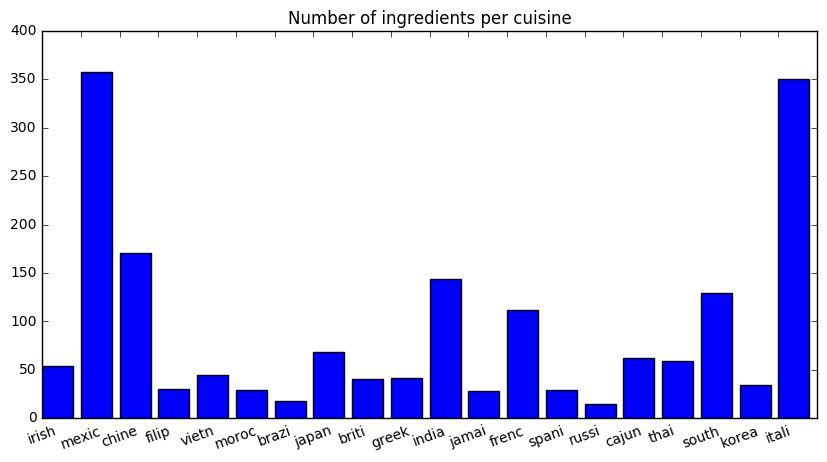

set([u'irish', u'mexican', u'chinese', u'filipino', u'vietnamese', u'moroccan', u'brazilian', u'japanese', u'british', u'greek', u'indian', u'jamaican', u'french', u'spanish', u'russian', u'cajun_creole', u'thai', u'southern_us', u'korean', u'italian'])


In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.close('all')

print [len([n for n in G if G.node[n]['single_cuisine_B'] == c]) for c in cuisine_types]
plt.figure(figsize=(10,5))
plt.bar(range(len(cuisine_types)), [len(ingredients_of_cuisine(G, c)[1]) for c in cuisine_types])
plt.title('Number of ingredients per cuisine')
plt.xticks(range(len(cuisine_types)), [c[:5] for c in cuisine_types], rotation=20)
plt.show()
print cuisine_types

We see that it's very irregular, and mexican and italian have **ten times more ingredients** than brazilian or spanish.

We are affraid that this is just a characterisitic of our dataset and that there isn't much that we can do. To check that it's not due to our assignment of ingredients to a single cuisine we'll plot the number of recipes that we have per cuisine.

[54, 357, 171, 30, 45, 29, 18, 68, 41, 42, 144, 28, 112, 29, 15, 62, 59, 129, 34, 350]


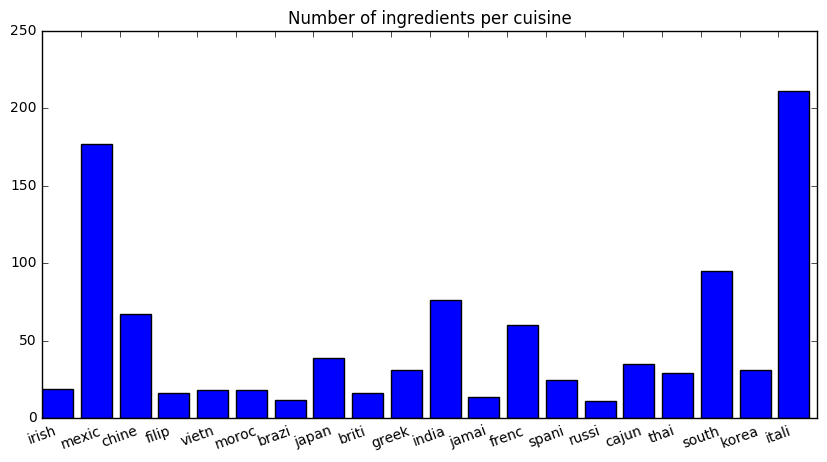

set([u'irish', u'mexican', u'chinese', u'filipino', u'vietnamese', u'moroccan', u'brazilian', u'japanese', u'british', u'greek', u'indian', u'jamaican', u'french', u'spanish', u'russian', u'cajun_creole', u'thai', u'southern_us', u'korean', u'italian'])


In [24]:
plt.close('all')

print [len([n for n in G if G.node[n]['single_cuisine_B'] == c]) for c in cuisine_types]
plt.figure(figsize=(10,5))
plt.bar(range(len(cuisine_types)), [len([r for r in recipes.values() if r['cuisine'] == c]) for c in cuisine_types])
plt.title('Number of ingredients per cuisine')
plt.xticks(range(len(cuisine_types)), [c[:5] for c in cuisine_types], rotation=20)
plt.show()
print cuisine_types

We see that the distribution of the ammount of recipes follows a similar pattern to the ammount of ingredients per cuisine so we can't say our assignment was farfetched.

## Network indicators, node relevance

We want to find what nodes are more relevant in the network, specially for each different cuisine. The goal is to find the most representative ingredients of every cuisine. To achieve that, we will compile a set of indicators that are candidates to give us useful information about nodes' relevance inside their community's subgraph.

One of the indicators will the the **TF-IDF** so we start creating the algorithm. The term frequency will show **how common is an ingredient within its cuisine**. The inverse document frequency will consider the different communities as documents, so if an ingredient belongs to many different cuisines (e.g. salt), its IDF will be lower.

In [25]:
from __future__ import division
import math

def tf(ingredient, cuisine):
    # TODO: cuisine might just be inferred from the ingredient? 
    #       (by looking at G.node[ingredient][single_cuisine_B])
    # cuisine = G.node[ingredient]['single_cuisine_B']
    
    # TF(t) = (Number of times term t appears in a document) / 
    #            (Total number of terms in the document)
    preferred_indicator = 'degree_cent'
    
    recipes_cuisine = [r for r in recipes.values() if r['cuisine'] == cuisine]
    
    # number of *recipes* of this cuisine
    appearances = [r for r in recipes_cuisine if ingredient in r['ingredients']]
    
    return len(appearances) / len(recipes_cuisine)
    
    n = len(recipes_cuisine)
    #return info_cusines[cuisine][preferred_indicator][ingredient] / n


def idf(ingredient, cuisines):
    ''' Return the Inverse Document Frequency of ingredient'''
    
    return math.log(len(recipes) / 
                    len(cuisines), 5)
    
def tfidf(ingredient, cuisine, cuisines):
    return tf(ingredient, cuisine) * idf(ingredient, cuisines)

In [26]:
# Examples to test the TF-IDF
print tf('soy sauce', 'chinese')
print idf('soy sauce', G.node['soy sauce']['cuisines'])
print tfidf('soy sauce', 'chinese', G.node['soy sauce']['cuisines'])
print tfidf('salt', 'jamaican', G.node['salt']['cuisines'])
G.node['soy sauce']['cuisines']

0.522388059701
2.92681728525
1.52893440274
1.56257778733


{u'chinese',
 u'filipino',
 u'indian',
 u'jamaican',
 u'japanese',
 u'korean',
 u'mexican',
 u'thai',
 u'vietnamese'}

In [27]:
# Let's compute the following indicators for the nodes of G
indicators = {'degree', 'betweenness_cent', 'degree_cent', 'eigen_cent', 'tf-idf'}

# Dict of dicts so that
# info_cuisines['thai']['degree']
# holds the degrees of the thai subgraph
info_cusines = dict.fromkeys(cuisine_types)
for c in info_cusines:
    info_cusines[c] = dict.fromkeys(indicators)

# info_cusines['thai']['degree'] = {'salt': 23, 'soy sauce': 79}
# info_cusines['thai']

In [28]:
nodes_cuisine = dict()

for c in info_cusines:
    print 'Working with %s:' % c,
    
    nodes_cuisine[c] = [n for n in G if G.node[n]['single_cuisine_B'] == c]
    print '%d nodes.' % len(nodes_cuisine[c]),
    csubgraph = G.subgraph(nodes_cuisine[c])
    
    print 'degree,',
    # info_cusines[c]['degree'] = nx.degree(G, nbunch=nodes_cuisine, weight='weight')
    info_cusines[c]['degree'] = nx.degree(csubgraph, weight='weight')
        
    print 'betweenness_cent,', 
    info_cusines[c]['betweenness_cent'] = nx.betweenness_centrality(csubgraph, weight='weight')
    
    print 'degree_cent,',
    info_cusines[c]['degree_cent'] = nx.degree_centrality(csubgraph)
    
    print 'eigen_cent',
    try:
        info_cusines[c]['eigen_cent']  = nx.eigenvector_centrality(csubgraph, max_iter=700)
    except nx.NetworkXError as e:
        print 'Couldnt compute eigen_cent for %s: %s %s' % (c, str(type(e)), str(e))
        
    print 'tf-idf'
    info_cusines[c]['tf-idf'] = {n: tfidf(n, c, G.node[n]['cuisines']) for n in nodes_cuisine[c]}


Working with irish: 54 nodes. degree, betweenness_cent, degree_cent, eigen_cent tf-idf
Working with mexican: 357 nodes. degree, betweenness_cent, degree_cent, eigen_cent tf-idf
Working with filipino: 30 nodes. degree, betweenness_cent, degree_cent, eigen_cent tf-idf
Working with chinese: 171 nodes. degree, betweenness_cent, degree_cent, eigen_cent tf-idf
Working with vietnamese: 45 nodes. degree, betweenness_cent, degree_cent, eigen_cent tf-idf
Working with spanish: 29 nodes. degree, betweenness_cent, degree_cent, eigen_cent tf-idf
Working with japanese: 68 nodes. degree, betweenness_cent, degree_cent, eigen_cent tf-idf
Working with moroccan: 29 nodes. degree, betweenness_cent, degree_cent, eigen_cent tf-idf
Working with french: 112 nodes. degree, betweenness_cent, degree_cent, eigen_cent tf-idf
Working with greek: 42 nodes. degree, betweenness_cent, degree_cent, eigen_cent tf-idf
Working with indian: 144 nodes. degree, betweenness_cent, degree_cent, eigen_cent tf-idf
Working with jama

To visualize the results, we'll generate a table with the higher values of each indicator and save it as a text file.

In [29]:
tables = ''

for ind in indicators:
    print ind
    tables += '\n\n\n' + ind + ': \n\n'
    
    data = [[i+1] + [sorted(info_cusines[c][ind], key=info_cusines[c][ind].get, reverse=True)[i] for c in list(cuisine_types)] for i in range(10)]
    
    tables += tabulate(data, headers=list(cuisine_types))
    
with io.open('./indicator_results.txt', 'w', encoding='utf-8') as f:
    f.write(tables)
    
print 'Done.'

degree
tf-idf
betweenness_cent
degree_cent
eigen_cent
Done.


In [30]:
# Understanding the difference between degree and degree_centrality

l =  info_cusines['japanese']
print len(l['degree_cent'].keys())
nodes_jap = [n for n in G.node if G.node[n]['single_cuisine_B']]
print len(nodes_jap)
print len(G.subgraph(nodes_jap).node)
data = [(i, l['degree'][i], l['degree_cent'][i]) for i in l['degree'].keys()[:20]]
print tabulate(sorted(data, key=lambda x: x[1], reverse=True), headers=('degree', 'degree_cent'))

68
1817
1817
                           degree    degree_cent
-----------------------  --------  -------------
panko breadcrumbs              26      0.119403
extra large eggs               14      0.104478
Himalayan salt                 14      0.119403
ramen noodles                  14      0.104478
caster                         14      0.104478
karashi                        14      0.119403
lemon cucumber                 14      0.119403
tea bags                       12      0.0895522
green tea powder               10      0.0895522
mixed greens                   10      0.0746269
miso                            6      0.0447761
sushi rice                      6      0.0447761
miso paste                      6      0.0597015
silken tofu                     6      0.0597015
boneless chicken thighs         6      0.0597015
fresh asparagus                 6      0.0597015
dashi kombu                     4      0.0447761
matcha green tea powder         4      0.0447761
maida flour   

Let's dive deeper into the meaning of the computed indicators. First, what's the **difference between degree and degree centrality**?

Degree centrality of a node n is degree(n)/number_of_nodes, where degree(n) is the _simple degree_ -**ignoring the weights!**
Let's take as an example two nodes that have the same degree. Degree centrality is giving more importance to the ingredient that is connected to a higher number different ingredients, over an ingredient that shares many recipes with a fewer number of ingredients. That explains the differences between these two rankings.

**Betweenness centrality**: as we know betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. In our network, it quantifies the number of times an ingredient is on the way between two ingredients, if we tried to navigate between ingredients following the edges denoted by the shared recipes. Even if it measures the centrality of a node, it doesn't have a clear physical meaning in our dataset.

**Eigenvector centrality** assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. That is, being connected to a hub or a node that is close to a hub gives a high score. Again, it's not a bad measure of centrality but it doesn't carry a strong stand-alone meaning. 

Examining the generated text file, we see that there are subtle differences in the top ten of values for the different indicators. The difference though, is mainly the order of the ingredients, but in each cuisine we see that the ingredients in the different top 10s are almost the same, so we'll consider them all good to get us to our goal. These rankings let us, as we hoped, see the most important ingredients of each cuisine!

## Communities

Our next goal is to analyse the communities present in our network. Our first hypotheses is that the cuisines are communities that show the modularity of the network. We will start by computing the modularity of the cuisine partition. We'll then find the best partition with Louvain's method and then compare the obtained modularity -which is the _optimal_ since the _best partition_ is the one that maximises the modularity.

In [31]:
import community as cm

#first compute the best partition
louvain_partition = cm.best_partition(G)

In [32]:
# We use the modularity function to calculate the louvain modularity
print "The modularity for the louvain partition is %f." % cm.modularity(louvain_partition, G)

cuisine_partition = dict((n, G.node[n]['single_cuisine_B']) for n in G.node)
print "The modularity for the cuisine partition is %f." % cm.modularity(cuisine_partition, G)

random_partition = dict((n, random.choice(range(20))) for n in G.node)
print "The modularity for a partition found randomly is %f." % cm.modularity(random_partition, G)

The modularity for the louvain partition is 0.285239.
The modularity for the cuisine partition is 0.209728.
The modularity for a partition found randomly is 0.070348.


We see that the lovain partition achieves a 36% higher modularity than the cuisines, so we found a slightly better way to group the ingredients than the cuisine they belong to. According to Louvain's heuristics, of course. The modularity of the cuisine partition isn't low enough to say it's a bad partition, we see that it indeed shows part of the community structure present in the network. It is, certainly, much higher than the modularity of a random partition, which doesn't come as a surprise.

How is the Louvain partition we found?

In [33]:
components_louvain = set(louvain_partition.values())
print components_louvain

set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])


Let's generate a Confusion matrix to see the elements shared between the communities found by the two different methods.

In [34]:
Dmat = dict.fromkeys(cuisine_types)

for i, c in enumerate(Dmat):
    Dmat[c] = []
    for j in components_louvain:
        Dmat[c].append(len([x for x in G.nodes_iter() if cuisine_partition[x] == c and louvain_partition[x] == j]))

In [35]:
with io.open('./confusion_matrix.txt', 'w', encoding='utf-8') as f:
    f.write(tabulate(Dmat, headers="keys"))


print tabulate(Dmat, headers="keys")

  irish    mexican    filipino    chinese    vietnamese    spanish    japanese    moroccan    french    greek    indian    jamaican    british    brazilian    russian    cajun_creole    thai    southern_us    korean    italian
-------  ---------  ----------  ---------  ------------  ---------  ----------  ----------  --------  -------  --------  ----------  ---------  -----------  ---------  --------------  ------  -------------  --------  ---------
      5         32           0          3             1          8           2           9        42       23         6           2          5            2          0               6       5             10         1        215
     16         42          10         19             5          5           4          11         4        8       113          19          0            4          2               9       3              6         1         14
      1        224           0          8             1          0           1           0  

(We recommend opening [the generated 'confusion_matrix.txt'](https://paste.cat/w6PbmH) rather than trying to read the table from the previous code output). ([Try here](http://networksare.life/confusion_matrix.txt) if the previous link is down)

We can observe a few interesting things on the confusion matrix. The Louvain partition **contains 15 communities**. That is 5 less communities than cuisine types we have, so cuisine types have been merged to form broader communities. As a perfect example let's take a look at the 4th Louvain community (4th row of the confusion matrix). It has a big ammount of chinese ingredients, followed by many japanese, thai, vietnamese and korean ingredients. In fact, we see that the _asian cuisine_ is one single community according to Louvain's partition! The nodes belonging to asian types of cuisine aren't _separated_ enough between each other too be considered different communities according to Lovuain's heuristics. 

Similar effects can be seen in other rows of the confusion matrix, like the 1st one, that contains a high number of italian ingredients but also french and mexican, suggesting that there are many common ingredients between recipes of those cuisines.

## Twitter analysis

In [1]:
# We initialize the libraries needed to work with twitter and create interactive graphics
from TwitterAPI import TwitterAPI
import json
import twitter
import time
import string
from nltk.corpus import words
import io
import numpy as np
from IPython.display import display
import plotly.tools as tls
import pandas as pd

import plotly.plotly as py # interactive graphing
from plotly.graph_objs import Bar, Scatter, Marker, Layout

# We set the authorization needed to get tweets
CONSUMER_KEY = 'XX'
CONSUMER_SECRET = 'XX'
ACCESS_TOKEN_KEY = 'XX'
ACCESS_TOKEN_SECRET = 'XX'


auth = twitter.oauth.OAuth(ACCESS_TOKEN_KEY, ACCESS_TOKEN_SECRET, CONSUMER_KEY, CONSUMER_SECRET)
twitter_api = twitter.Twitter(auth=auth,retry=True)       

In [2]:
# Creating a list with the names of the types of cuisines we are analyzing

cuisines=['irish cuisine', 'mexican cuisine', 'chinese cuisine', 'filipino cuisine', 'vietnamese cuisine', 'moroccan cuisine', 'brazilian cuisine', 'japanese cuisine', 'british cuisine', 'greek cuisine', 
          'indian cuisine', 'jamaican cuisine', 'french cuisine','spanish cuisine', 'russian cuisine', 'cajun_creole cuisine', 'thai cuisine', 'american cuisine', 'korean cuisine', 'italian cuisine']

 # Dictionary (keys: type of cuisines and values: tweets)
dict_tweets= {c:[] for c in cuisines}

In [ ]:
# For each cuisine we search for the tweets that has been posted in the last week. We search for them by the names of the list.

for cui in cuisines:
    SEARCH_TERM = cui
    count=200
    
    # We set the amount of tweets fetched to 200, however we have proved that we can only get 100 each time as max.
    results = twitter_api.search.tweets(q = SEARCH_TERM,count=count)
    statuses = results['statuses']

    print cui.upper()
    # Number of tweets per cuisine
    l=len(statuses)
    print ("We have %d statuses" %l)

    # We decide to iterate over 16 times to try to get 1600 tweets per cuisine, even though in some of them there will be less
    # because there are no more post with those characteristics
    # In this part, we get the id number of the last tweet of each iteration and insert it for doing the new request of tweets(here**)
    for i in range (0,15):
        for _ in range(5):
            try:
                next_results = results['search_metadata']['next_results']
            except KeyError, e: # No more results when next_results doesn't exist
                break

        # Create a dictionary from next_results, which has the following form:
        kwargs = dict([ kv.split('=') for kv in next_results[1:].split("&") ])
        results = twitter_api.search.tweets(**kwargs ) # (here**)
        statuses += results['statuses']

        # Checking number of tweets in total
        l=len(statuses)
        print ("We have %d statuses" %l)


        tweets=[] # List of tweets per cuisine

        # We change the format of the tweets to json and add them into a list
        for status in statuses:
            j=json.dumps(status['text'], indent=1)
            tweets.append(j)

    # We insert each list of tweets per cuisine in the dictionary
    dict_tweets[cui].extend(tweets)

In [ ]:
# Save the tweets into a file:
with open('tweetsfile.json', 'w') as f:
    json.dump(dict_tweets, f)


In [7]:

# We check how many tweets are just the same one, this is because we want to make sure that we are not fetching the same
# tweets over and over again. We conclude to get some tweets that are the same and this could be dut to retweeting, because 
# there are not an excessive amount of each.
from collections import Counter

cnt=Counter()
# E.g: Checking number of the same tweets in Mexican cuisine
for tweet in dict_tweets['mexican cuisine']:
    cnt[tweet]+=1
print cnt.values()[:3]

[2, 2, 2]


### Cleaning tweets

Now that we've fetched a list of tweets, we'll clean them before studying their content.

In [3]:
# Loading the content of the "tweetsfile"

with open('tweetsfile.json', 'r') as f:
    data = json.load(f)

In [9]:
# Testing if cleaning the punctuation in a particular tweet works.

exclude = set(string.punctuation)
data['brazilian cuisine'][0].replace("'", "")
data['brazilian cuisine'][0] = ''.join(ch for ch in data['brazilian cuisine'][0] if ch not in exclude)
data['brazilian cuisine'][0]

u'Stop by Wildfire amp do try our authentic Brazilian cuisine cooked with love by Chef Juarez G de Azevedou2026 httpstcop9pvvDngXA'

In [10]:
# Getting rid of the punctuation and words that don't exist in english for all the tweets.
# Tokenizing tweets and create a dictionary of tokens for each cuisine

data_clean={c:[] for c in cuisines} 
english_words = set(words.words())
data_tokens={c:[] for c in cuisines}


for cui in data_clean.keys():
    tweet_clean=[]
    tokens=[]
    for tweet in data[cui]:
        tweet.replace("'", "")
        tweet = ''.join(ch for ch in tweet if ch not in exclude)
        tweet=[word for word in tweet.split() if word in english_words]
        tokens.extend(tweet)
    data_tokens[cui].extend(tokens)
print data_tokens['brazilian cuisine'][:3]

[u'by', u'do', u'try']


In [31]:
# Save the dictionary of tokens in a file
with open('tokensfile.json', 'w') as f:
    json.dump(data_tokens, f)

### Sentiment Analysis

Time to start the analysis of the actual text!

In [3]:
# Open the file which contains the average happiness of some words.
f = io.open('Data_Set_S1.txt','r', encoding='utf-8')
data = f.read()
f.close()

In [4]:
# We load the file with the tokens
with open('tokensfile.json', 'r') as f:
    data1 = json.load(f)

In [5]:
# Create a dictionary in which we have as keys the words and as values their average sentiment.
sentiment_dict = {}
for line in (data.split('\n'))[1:-1]:
    try:
        sentiment_dict[line.split()[0]] = float(line.split()[2])
    except:
        print line
        raise

In [7]:
# Checking sentiment of word "happiness"
print sentiment_dict['happiness']

8.44


In [6]:
# Creating a funtion in which we will introduce the tokens for each cuisine and the dictionary of words with data of sentiment.
# We create a list in which we will have the average sentiment of each word, then we calculate the mean sentiment for that list
def sentiments(tokens, sentiment_dict):
    sent_list = [sentiment_dict[token] for token in tokens if token in sentiment_dict]
    
    if len(sent_list) == 0:
        print "The list has no sentimens... :_("
        return -1
    else:
        return float(np.mean(sent_list))


In [7]:
# Creating a dictionary with name of cuisines as keys and averagesentiment as values.
average_sent={c:'' for c in cuisines}

for cui in cuisines:
    sentiment=sentiments(data1[cui], sentiment_dict)
    average_sent[cui]=round(sentiment,2)
print average_sent

{'brazilian cuisine': 5.66, 'mexican cuisine': 5.6, 'irish cuisine': 5.68, 'italian cuisine': 5.58, 'french cuisine': 5.66, 'chinese cuisine': 5.74, 'vietnamese cuisine': 5.66, 'jamaican cuisine': 5.65, 'british cuisine': 5.45, 'greek cuisine': 5.6, 'filipino cuisine': 5.61, 'japanese cuisine': 5.62, 'korean cuisine': 5.57, 'moroccan cuisine': 5.65, 'spanish cuisine': 5.54, 'cajun_creole cuisine': 5.71, 'american cuisine': 5.0, 'thai cuisine': 5.7, 'indian cuisine': 5.68, 'russian cuisine': 5.68}


In [8]:
# Save the the value for the sentiment for each cuisine in a file
with open('sentimentfile.json', 'w') as f:
    json.dump(average_sent, f)

In [9]:
cocinas=[]
for key in average_sent.keys():
    cocinas.append(key[:-7])
print cocinas

['brazilian ', 'mexican ', 'irish ', 'italian ', 'french ', 'chinese ', 'vietnamese ', 'jamaican ', 'british ', 'greek ', 'filipino ', 'japanese ', 'korean ', 'moroccan ', 'spanish ', 'cajun_creole ', 'american ', 'thai ', 'indian ', 'russian ']


In [14]:
# Creating a chart in which we can see the average sentiment per type of cuisine
py.iplot({'data':[Bar(x=cocinas, y=average_sent.values())],
          'layout':Layout(barmode='stack', xaxis= {'tickangle': 40},yaxis={'range':[4.9,5.7]}, title='Sentiment per Cuisine')} ,
         filename='Sentiment per Cuisine')

### HEY!
Unfortunately the plots done by iplot **won't be visible from GitHub's visualizer**. [Try nbviwer](http://nbviewer.jupyter.org/github/ediblenetworks/SocialWeb/blob/master/Recipe_Analysis_Explainer.ipynb#HEY!) if you can't see them.

In [15]:
# Creating a chart in which we can see the average sentiment per type of cuisine(excluding America due to its low sentiment 
# and the big difference with the rest of cuisines)
py.iplot({'data':[Bar(x=cocinas, y=average_sent.values())],
          'layout':Layout(barmode='stack', xaxis= {'tickangle': 40},yaxis={'range':[5.4,5.7]}, title='Sentiment per Cuisine')} ,
         filename='Sentiment per Cuisine')

In [16]:
# Sentiment average per cuisine located in the world map

# Loading the file with the names of the countries and codes
cod = pd.read_csv('country.csv')


data = [ dict(
        type = 'choropleth',
        locations = cod['CODE'], # Introducing code per country
        z = average_sent.values(), # Introducing average happiness of each country
        text = cod['COUNTRY'], # Introducing country names
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            title = 'Grade of Happiness'),
      ) ]

layout = dict(
    title = 'Happiness av. per cuisine in the World',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

## Wordclouds

In order to visualize the content of the obtained tweets, we'll create a few wordclouds that show some of the results.

In [27]:
import json
import twitter
import time
import string
from nltk.corpus import words
import io
import numpy as np
from IPython.display import display
import plotly.tools as tls
import pandas as pd
from wordcloud import WordCloud
import plotly.plotly as py # interactive graphing
from plotly.graph_objs import Bar, Scatter, Marker, Layout
import matplotlib.pyplot as plt


In [3]:
cuisines=['irish cuisine', 'mexican cuisine', 'chinese cuisine', 'filipino cuisine', 'vietnamese cuisine', 'moroccan cuisine', 'brazilian cuisine', 'japanese cuisine', 'british cuisine', 'greek cuisine', 
          'indian cuisine', 'jamaican cuisine', 'french cuisine','spanish cuisine', 'russian cuisine', 'cajun_creole cuisine', 'thai cuisine', 'american cuisine', 'korean cuisine', 'italian cuisine']

dict_tweets= {c:[] for c in cuisines} # Dictionary (keys: type of cuisines and values: tweets )

In [4]:
with open('tweetsfile.json', 'r') as f:
    data = json.load(f)

In [29]:
exclude = set(string.punctuation)
data_clean={c:[] for c in cuisines} 
english_words = set(words.words())
data_tokens={c:[] for c in cuisines}


for cui in data_clean.keys():
    tweet_clean=[]
    tokens=[]
    print cui
    for tweet in data[cui]:
        tweet.replace("'", "")
        tweet = ''.join(ch for ch in tweet if ch not in exclude)
        tweet=[word for word in tweet.split() if word in english_words]
        tokens.extend(tweet)
    data_tokens[cui].extend(tokens)
#print data_tokens['brazilian cuisine']

brazilian cuisine
mexican cuisine
irish cuisine
italian cuisine
french cuisine
chinese cuisine
vietnamese cuisine
jamaican cuisine
british cuisine
greek cuisine
filipino cuisine
japanese cuisine
korean cuisine
moroccan cuisine
spanish cuisine
cajun_creole cuisine
american cuisine
thai cuisine
indian cuisine
russian cuisine


### Creating word clouds

In [7]:
# create a word count for each word in each cuisine
wordcount_cui = []
#For each cuisine in data_tokens
for cuisine in data_tokens.keys():
    #we create a wordset for each cuisine
    wordset = list(set(data_tokens[cuisine]))
    #Construct a dict with the set of tokens as keys and 0 as values
    word_dict = dict.fromkeys(wordset, 0)
    #we add +1 to the value each time a word appears in the tokens
    for word in data_tokens[cuisine]:
        word_dict[word]+=1
    wordcount_cui.append(word_dict) 

In [10]:
#we create the TF function
def TF(word_dict):
    #we create a dict to store the TF
    tfdict = {}
    #we iterate and compute TF
    for word, count in word_dict.iteritems():
        tfdict[word] = 1 + np.log(count)
    return tfdict

#initializa a list for TF per cuisine
TF_cuisine = []
#We append TF for each cuisine
for index in xrange(len(data_tokens)):
    word_dict = wordcount_cui[index]
    tf = TF(word_dict)
    TF_cuisine.append(tf)

In [13]:
#we define the IDF function
def IDF(cuisine_num,idf_dict):
    #obtain the number of cuisines we have
    N = len(cuisine_num)
    #we compute IDF for each cuisine
    for cui in cuisine_num:
        for word, value in cui.iteritems():
            if value > 0:
                idf_dict[word] +=1
    for word, value in idf_dict.iteritems():
        idf_dict[word]= np.log(N / float(abs(value))) 
    return idf_dict

#we define the TF_IDF function
def TFIDF(tf, idfs):
    #create a dict to store TF_IDF
    tf_idf = {}
    #multiply TF and IDF for each word
    for word, val in tf.iteritems():
        tf_idf[word] = val * idfs[word]
    return tf_idf

#we create a dict with the words from each cuisine
dic = dict(wordcount_cui[0].items() + wordcount_cui[1].items() +  wordcount_cui[2].items() + 
           wordcount_cui[3].items() +  wordcount_cui[4].items() + wordcount_cui[5].items() +
           wordcount_cui[6].items() + wordcount_cui[7].items() +  wordcount_cui[8].items() +
           wordcount_cui[9].items() + wordcount_cui[10].items() +  wordcount_cui[11].items() +
           wordcount_cui[12].items() + wordcount_cui[13].items() +  wordcount_cui[14].items() +
           wordcount_cui[15].items() + wordcount_cui[16].items() +  wordcount_cui[17].items() +
           wordcount_cui[18].items() + wordcount_cui[19].items() )

#we initialize a dict with the words as keys an 0 as values
idf_dict = dict.fromkeys(dic.keys(),0)

#call the IDF function.
idfs = IDF(wordcount_cui,idf_dict)

#call the TF_IDF function for each cuisine
tfidf_x_cuisine = []
for cui in xrange(len(data_tokens)):
    tfidf =  TFIDF(TF_cuisine[cui], idfs)
    tfidf_x_cuisine.append(tfidf)

In [23]:
#define the function to round the TF_IDF
def RoundTFIDF(tfidf_x_cuisine):
    #initialize the list to store it
    tfidf_cuisine_round = []
    for index in xrange(len(tfidf_x_cuisine)):
        tfidf_round = {}
        #For each cuisine
        for word,value in tfidf_x_cuisine[index].iteritems():
            #Round the TFIDF value
            tfidf_round[word] = int(round(value))
        tfidf_cuisine_round.append(tfidf_round)
    return tfidf_cuisine_round

#Call RoundTFIDF function
tfidf_cuisine_round = RoundTFIDF(tfidf_x_cuisine)

#Define LongString function
def LongString(tfidf_cuisine_round):
    #initialize the list to store it
    long_string_x_cui = []
    #For each cuisine
    for cui in xrange(len(tfidf_cuisine_round)):
        long_string_cui = []
        #For each cuisine
        for word,value in tfidf_cuisine_round[cui].iteritems():
            #If the rounded TF_IDF is bigger than 0 repeat the word value number of times
            if value > 0:
                long_string_cui.extend(np.repeat(word,value))
        #join them separated by space
        long_string_x_cui.append(' '.join(long_string_cui))
    return long_string_x_cui

#Call CreateLongString function
long_string_x_cui = LongString(tfidf_cuisine_round)

#Define WordCloud function
def Word_Cloud(long_string_x_cui,cuisines):
    twitter_mask = imread('food-solid.png', flatten=True)

    #For each cuisine
    for index,cuisine in enumerate(cuisines):
        cuisine = cuisine.replace("_"," ")
        print cuisine
        #Generate WordCloud with longstring build above
        wordcloud = WordCloud(background_color='white').generate(long_string_x_cui[index])
        img=plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        #plt.savefig('wordcloud_%s.png' %name,dpi=1800)

brazilian cuisine


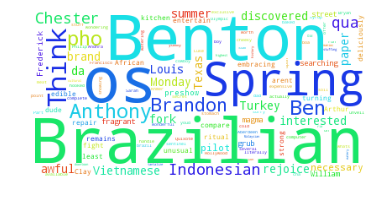

mexican cuisine


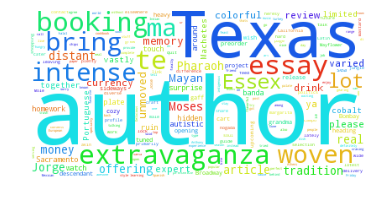

irish cuisine


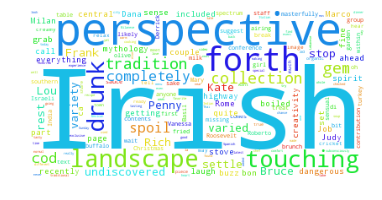

italian cuisine


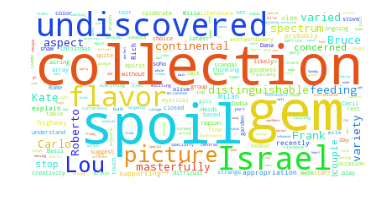

french cuisine


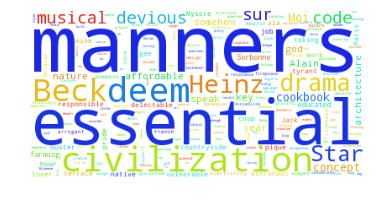

chinese cuisine


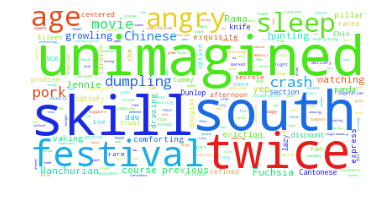

vietnamese cuisine


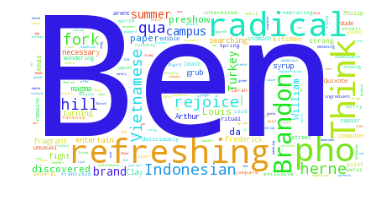

jamaican cuisine


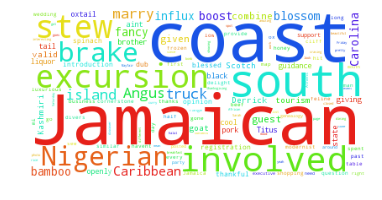

british cuisine


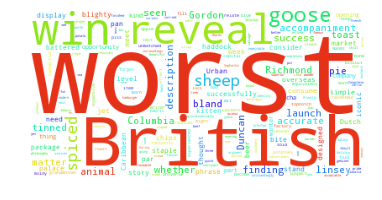

greek cuisine


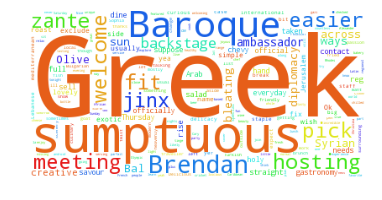

filipino cuisine


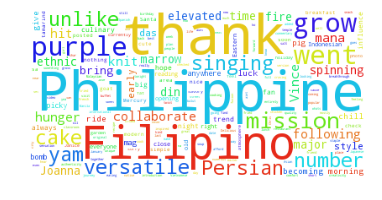

japanese cuisine


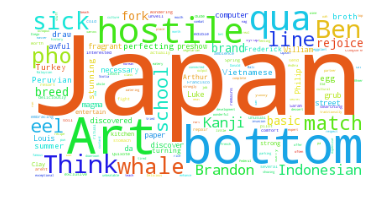

korean cuisine


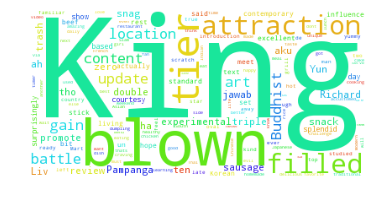

moroccan cuisine


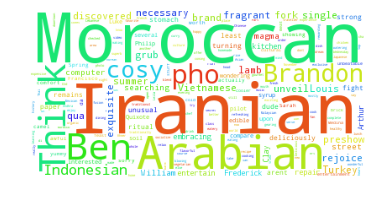

spanish cuisine


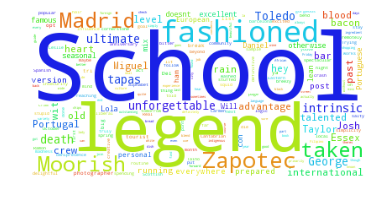

cajun creole cuisine


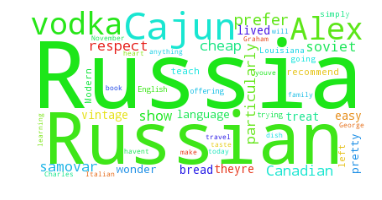

american cuisine


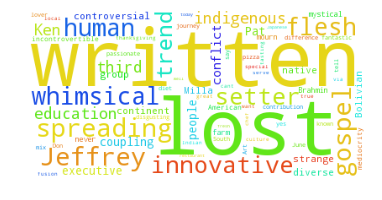

thai cuisine


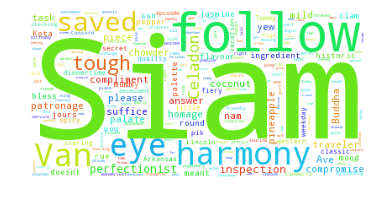

indian cuisine


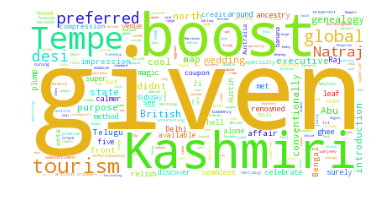

russian cuisine


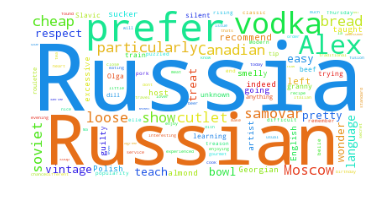

In [28]:
%matplotlib inline

Word_Cloud(long_string_x_cui,data_tokens.keys())

If we now take a look at the wordclouds we can generate for each type of cuisine, we can better observe where does the sentiment come from. In other words, do high rated cuisines have frequent words that reflect those sentiments? 
Taking a look at the wordclouds we do see some relation between the sentiment a the most representative words. For example, they seem to tell us that the british cuisine is the words...We also have terms like _lost_ or _whimsical_ for american cuisine. On the other hand, the chinese cuisine has terms like _sill, festival, dumpling, cantonese, pork_, and the thai cuisine terms like _siam, harmony, or buddha_. In conclusion, even thougth the words are not strictly related to food, their positive or negative connotations can be appreciated.

## Recipe name generator

The dataset we've been using has allowed us so far to find the most common ingredients, the most representative ingredients of the different cuisines, to check that cuisines form communities, and to find a partition better than the cuisines. What else could we achieve with it? One could think of comparing recipe names across cuisines, or to build a reccommender of a recipe given certain ingredients -or another recipe. But for some of these applications we would do better if the dataset included the recipe names. Note that we have the recipes as a list of ingredients but we don't know their name... 

That gave us the idea of trying to generate a name ourselves. We'll build a function that comes up with a name for the given recipe. We don't expect great results, but it is a good way of applying the measures and indicators we've computed so far and to see how useful they are in overcoming the expected inconvenients of our limited method. Note that we don't have the recipe preparation steps either so we can't really know how are the ingredients combined. We'll also add a touch of humor to the generated names. They will consist basically of two **important** ingredients of the given recipe, joined by some preposition and embellished by -often pompous- adjectives.

In [36]:
def recipe_name(r):
    '''Comes up with a recipe name for r'''
    
    prepositions = ['filled with','and','with','in','above','under','beneath','into','on','with a touch of','of','between','beside','inside','from']
    adjectives   = ['amazing', 'disgusting', 'smelly', 'stinky', 'nasty', 'burned', 'classic', 'tasty', 'cool','crispy', 'creamy', 'delicious', 'fresh', 'freezing', 'gorgeous', 'healthy', 'icy', 'light', 'low-fat', 'marinated', 'spicy', 'minty', 'mild', 'natural', 'oily', 'salty', 'soporific', 'flavourless', 'seasoned', 'smoked', 'silky', 'sprinkled', 'spongy', 'succulent', 'sweet', 'syrupy', 'tender', 'terrific', 'tough', 'traditional','waxy', 'yummy', 'wonderful', 'yucky','zingy']

    
    cuisine = r['cuisine']
    # tf_idf = [(i, tfidf(i, cuisine, G.node[i]['cuisines'])) for i in r['ingredients']]
    degree_cent = [(i, info_cusines[cuisine]['degree_cent'][i]) for i in r['ingredients'] if G.node[i]['single_cuisine_B'] == cuisine]
    
    if len(degree_cent) == 0:
        degree_cent = [(i, info_cusines[G.node[i]['single_cuisine_B']]['degree_cent'][i]) for i in r['ingredients']]

    ranking_ing = sorted(degree_cent, key=lambda x: x[1], reverse=True)
    names_ranking = [a for a, b in ranking_ing]
    
    #print tabulate(ranking_ing)
    
    if len(names_ranking) < 2:
        name = random.choice(adjectives) + ' ' + names_ranking[0]
    else:
        ingredient1 = random.choice(names_ranking[1:])
        ingredient2 = names_ranking[0]
        name = ' '.join([random.choice(adjectives), ingredient1, random.choice(prepositions), ingredient2])
    return name

After a few different tries, we decide to stick with the degree centrality. The tf-idf yielded some interesting results as well but it gave a lot of importance to very common nodes. See a few examples of resulting names:

In [37]:
r = recipes[45193]
r = random.choice(recipes.values())
print r
print recipe_name(r)

{u'cuisine': u'british', u'id': 7473, u'ingredients': [u'demerara sugar', u'egg whites', u'fruit', u'butter', u'dried currants', u'frozen pastry puff sheets', u'mixed spice', u'white sugar']}
wonderful fruit with dried currants


In [38]:
for i in range(5):
    r = random.choice(recipes.values())
    #print 'Ingredients: ' + ', '.join(r['ingredients'])
    print '%s' % recipe_name(r)

smoked pickapeppa sauce above bread crumbs
disgusting red beets into dill
succulent arborio rice inside ground black pepper
terrific cilantro leaves beside chili powder
classic fontina with a touch of grated parmesan cheese


As we said, it's a very naïve method but the results are satisfactory enough. By chosing a random ingredient plus the one with greatest degree centrality of the recipe cuisine we try to minimise the generation of names like _salt with pepper_. 

# 4. Discussion

As a conclusion, we'll discuss the result of this project.

On one hand, we are happy about the outcome. We were successful on applying network analysis tools on a dataset that, at least at first, does not necessarily look as a network. We were able to build a network that let us find communities inside, check how these communities match the world cuisines, and find out about the most characteristic ingredients of each cusine based on node centrality measures. We built a fun name generator that didn't perform as badly as expected. We fetched an important amount of tweets and extracted its sentiment, finding the most beloved cuisines. And we visualised all this data in relatively nice ways, including wordclouds. All this leaves us satisfied and proud.

On the other hand, we are aware of the limitations of the presented analysis. Even if interesting, the conclusions and results we showed don't any provide novel breakthrough or discovery in food studies or network science. Actually, the usefulness of the work can be discussed too, since it's not a direct service to users that we're releasing. The number of tweets analysed was limited by the API and time restrictions. The name generator is a fun but toy-ish tool. 

As to how to improve our work, we would like to learn more about interactive visualisation so that we can present more interesting data and networks in the website. A deeper knowledge of JavaScript and a longer time would let us move part of the analysis to the browser and make it more accessible. We could also dive deeper in the network analysis and find what nodes (ingredients) act as links between different cuisines.

The authors would like to end this creation by thanking everyone who has read this work.